# 3 DoF Planar Drone Landing Problem
> Ramchander Bhaskara, PhD, Texas A&M University

## Problem Statement

The control problem is for a tandem dual-rotor system where the drone is actuated by two thrusters at both ends of a beam (chassis). The position and pitch can be controlled by controlling the thrust. 

The vehicle motion is described by only 3 Degrees of Freedom (3DoF), as follows:
-  $x$ : lateral position
-  $y$ : altitude
-  $\theta$ : attitude angle (pitch)
  


## Dynamics
Here is a drawing describing the derivation of the equations of motion: 

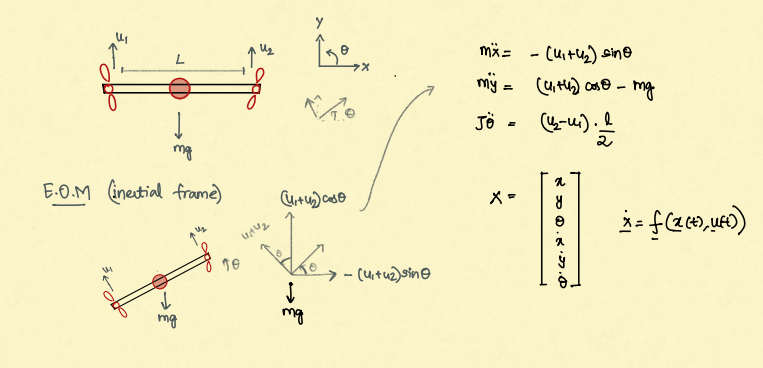

### Equations of motion
$$\begin{align} 
\dot{x} &= v_x  \\ 
\dot{y} &= v_y \\
\dot{\theta} &= \omega \\
\dot{v_x} &= -\frac{(u_1 + u_2)}{m} \sin(\theta) \\
\dot{v_y} &= \frac{(u_1 + u_2)}{m} \cos(\theta) - g \\
\dot{\omega} &= \frac{(u_2 - u_1)}{J} \cdot \frac{L}{2}
\end{align}$$

# MPC: Receding Horizon Control

MPC looks for optimal control law in the finite horizon (for N steps). It takes a cost minimizing step towards the goal - only for the fixed horizon. After executing the control for that step, it slides the horizon window, incorporates new information from trajectory, and computes the control towards the goal. 

## Objective Function
$$J = \frac{1}{2} (\mathbf{x}_N - \mathbf{x}_\text{ref})^T \mathbf{Q}_N (\mathbf{x}_N - \mathbf{x}_\text{ref}) + \sum_{k = 1}^{N} \frac{1}{2}(\mathbf{x}_k - \mathbf{x}_\text{ref})^T \mathbf{Q} (\mathbf{x}_k - \mathbf{x}_\text{ref}) + \frac{1}{2} (\mathbf{u}_k - \mathbf{u}_\text{ref})^T \mathbf{R} (\mathbf{u}_k - \mathbf{u}_\text{ref})$$ 
 

The penalty on terminal states, deviation from nominal trajectory and control is a convex optimization problem solved using quadratic programming. 
OSQP

  $$ {\text{argmin}}_{\mathbf{z}} \quad \frac{1}{2} \mathbf{z}' \mathbf{H} \mathbf{z} + \mathbf{g}' \mathbf{z} $$
   $$ \text{subject to} \quad \mathbf{lb} \leq \mathbf{A}_c \mathbf{z} \leq \mathbf{ub}$$
where $z: n \times 1$ | $\mathbf{H}: n \times n$ | $ \mathbf{g}: n \times 1$ | $\mathbf{A}_c: m \times n$ ($m$ constraints)   

$\mathbf{z} = [\mathbf{x}_0, \mathbf{x}_1, \dots, \mathbf{x}_N, \mathbf{u}_0, \dots, \mathbf{u}_{N-1}]$

## MPC implementation
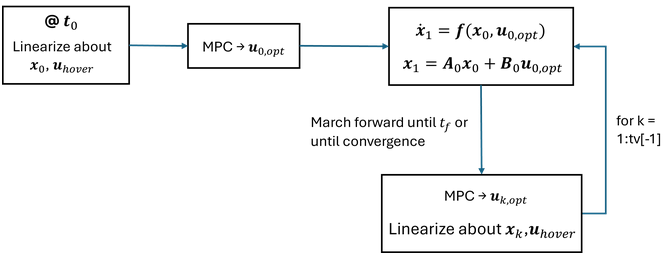

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
import control
import osqp
from IPython.display import display, Math, Latex
import scipy as sp
import time

class MPC_Controller:
    def __init__(self, N_horizon, Q, R, Qf, x_init, x_ref):
        self.g = 9.81
        self.m = 1.0
        self.L = 0.3
        self.J = 0.2 * self.m * self.L * self.L
        self.h = 0.05 # 20 Hz

        self.umin = [0.2*m*g, 0.2*m*g] # deadband min thrust, delta
        self.umax = [0.8*m*g, 0.8*m*g] # [thrust, delta] 
        self.u_hover = [0.5*m*g, 0.5*m*g]
        
        self.N = N_horizon
        self.nx = Q.shape[0]
        self.nu = R.shape[0]
        self.Q = Q
        self.R = R
        self.Qf = Qf
        self.x0 = x_init
        self.u_init = self.u_hover # for linearization
        self.x_ref = x_ref

        self.nz = (self.N+1)*self.nx + self.N*self.nu # z: total no. of variables in QP: [x0; x1,..,x_N; u0, u...u_N-1]
        
        # OSQP Solver
        self._build_cost_matrix()
        self._build_constraint_matrix()
        self.prob = osqp.OSQP()
        self._setup_osqp()
        

    def drone_dynamics(self, x, u):
        x = jnp.array(x)
        u = jnp.array(u)
        theta = x[2]
        x_ddot = -(1/self.m) * (u[0] + u[1]) * jnp.sin(theta)
        y_ddot = (1/self.m) * (u[0] + u[1]) * jnp.cos(theta) - g
        theta_ddot = (1/self.J) * (self.L/2) * (u[1] - u[0])
        
        Xdot = jnp.array([x[3], x[4], x[5], x_ddot, y_ddot, theta_ddot])
        return Xdot

    def drone_dynamics_rk4(self,x,u):
        x = jnp.array(x)
        u = jnp.array(u)
        f1 = self.drone_dynamics(x, u)
        f2 = self.drone_dynamics(x + 0.5*self.h*f1, u)
        f3 = self.drone_dynamics(x + 0.5*self.h*f2, u)
        f4 = self.drone_dynamics(x + self.h*f3, u)
        return jnp.array(x + (self.h/6.0)*(f1 + 2*f2 + 2*f3 + f4))
    
    def linearized_dynamics(self, x, u):
        x = jnp.array(x)
        u = jnp.array(u)
        Ak = jax.jacfwd(self.drone_dynamics_rk4, argnums=0)(x, u)
        Bk = jax.jacfwd(self.drone_dynamics_rk4, argnums=1)(x, u)
        Ck = self.drone_dynamics_rk4(x, u) - Ak @ x - Bk @ u
        return jnp.array(Ak), jnp.array(Bk), jnp.array(Ck)
    
    def _build_cost_matrix(self): 
        # Cost matrix H
        Qblk = sp.linalg.block_diag( np.kron( np.eye(self.N), self.Q ), self.Qf )
        Rblk = np.kron( np.eye(self.N), self.R )
        self.H_qp = sp.linalg.block_diag( Qblk, Rblk )
        # self.g_qp = np.hstack( [np.zeros(self.nx*self.N), -self.Qf @ self.x_ref, np.zeros(self.nu*self.N)] )

    def _build_constraint_matrix(self):
        self.n_constraints = self.nx + self.N*self.nx + self.N*self.nx + self.N*self.nu # x0, x-dynamics, x-bounds, u-bounds
        self.Ac = np.zeros((self.n_constraints, self.nz))
        
        Ix = np.eye(self.nx)
        Iu = np.eye(self.nu)

        Ak, Bk, Ck = self.linearized_dynamics(self.x0, self.u_hover)
        
        constraint_row = 0 # for x0 equality constraint
        row = slice(constraint_row, constraint_row + self.nx)
        col = slice(0, self.nx)
        self.Ac[row, col] = Ix
        
        constraint_row += self.nx

        # Dynamics constraints: Ak*xk + Bk*uk + Ck - x_{k+1} = 0
        # as: -x_{k+1} + Ak*xk + Bk*uk = -Ck
        
        self.dynamics_start_row = constraint_row
        
        for k in range(self.N):
            row = slice(constraint_row + k*self.nx, constraint_row + (k+1)*self.nx)
            # -x_{k+1} (constant)
            col_nxt = slice((k+1)*self.nx, (k+2)*self.nx)
            self.Ac[row, col_nxt] = -Ix
            # +Ak*xk
            col_curr = slice(k*self.nx, (k+1)*self.nx)  
            self.Ac[row, col_curr] = Ak  
            # +Bk*uk
            col_u = slice((self.N+1)*self.nx + k*self.nu, (self.N+1)*self.nx + (k+1)*self.nu)
            self.Ac[row, col_u] = Bk
        
        constraint_row += self.N*self.nx

        # State bounds
        self.state_bounds_start_row = constraint_row
        for k in range(self.N):
            row = slice(constraint_row + k*self.nx, constraint_row + (k+1)*self.nx)
            col = slice((k+1)*self.nx, (k+2)*self.nx)
            self.Ac[row, col] = Ix
        
        constraint_row += self.N*self.nx
        
        # Control bounds
        for k in range(self.N):
            row = slice(constraint_row + k*self.nu, constraint_row + (k+1)*self.nu)
            col = slice((self.N+1)*self.nx + k*self.nu, (self.N+1)*self.nx + (k+1)*self.nu)
            self.Ac[row, col] = Iu
    
    def _setup_osqp(self):
        P = sp.sparse.csc_matrix(self.H_qp) # H_qp is fixed -> setup once
        Ac = sp.sparse.csc_matrix(self.Ac)
        q_qp = np.zeros(self.nz)
        lb = np.zeros(self.n_constraints) 
        ub = np.zeros(self.n_constraints)

        # initial setup
        self.prob.setup(P=P, q=q_qp, A=Ac, l=lb, u=ub, 
                        verbose=False, eps_abs=1e-6, eps_rel=1e-6, 
                       max_iter=5000, adaptive_rho=True) # convergence

    def _update_dynamics_constraints(self, Ak, Bk):
        constraint_row = self.dynamics_start_row
        
        for k in range(self.N):
            row = slice(constraint_row + k*self.nx, constraint_row + (k+1)*self.nx)
            # +Ak*xk
            col_curr = slice(k*self.nx, (k+1)*self.nx)
            self.Ac[row, col_curr] = Ak
            # +Bk*uk  
            col_u = slice((self.N+1)*self.nx + k*self.nu, (self.N+1)*self.nx + (k+1)*self.nu)
            self.Ac[row, col_u] = Bk

    def solve_mpc(self, x_curr, x_ref, u_curr):
        # Linearization is key for solver to be working! Use LQR to study what works!
        # Linearization - small angle approximation
        Ak, Bk, Ck = self.linearized_dynamics(x_curr, self.u_hover)
        self._update_dynamics_constraints(Ak, Bk)
        
        # linear penalty term
        self.g_qp = np.hstack([
                    np.kron(np.ones(self.N), -self.Q @ x_ref),  # Intermediate states
                    -self.Qf @ x_ref,                           # Terminal state  
                    np.zeros(self.nu*self.N)                    # Controls
                ])
        # doesn't change for this example -> x_ref is x_f

        # Build updated bounds
        x_min = np.repeat(-np.inf, 6)
        x_min[1] = 0.0      # y >= 0
        x_min[2] = -np.deg2rad(20)   # theta >= -20 deg
        
        x_max = np.repeat(np.inf, 6)
        x_max[2] = np.deg2rad(20)    # theta <= 20 deg
        
        l_new = np.hstack([
            x_curr,                                          # Initial condition
            np.tile(-Ck, self.N),                             # Dynamics 
            np.tile(x_min, self.N),                           # State bounds
            np.tile(self.umin, self.N)                        # Control bounds  
        ])
        
        u_new = np.hstack([
            x_curr,                                          # Initial condition
            np.tile(-Ck, self.N),                             # Dynamics
            np.tile(x_max, self.N),                           # State bounds  
            np.tile(self.umax, self.N)                        # Control bounds
        ])

        # https://osqp.org/docs/examples/update-matrices.html
        # A_new = sp.sparse.csc_matrix(self.Ac)
        # self.prob.update(q=self.g_qp, l=l_new, u=u_new, Ax=A_new.data) # next revision of this code
        A = sp.sparse.csc_matrix(self.Ac)
        P = sp.sparse.csc_matrix(self.H_qp)
        self.prob = osqp.OSQP()
        self.prob.setup(P=P, q=self.g_qp, A=A, l=l_new, u=u_new, 
                        verbose=False, eps_abs=1e-6, eps_rel=1e-6, max_iter=5000) # expensive to setup everytime
        res = self.prob.solve()
        
        if res.info.status == 'solved':
            z_opt = res.x
            u_opt = z_opt[(self.N+1)*self.nx : ].reshape(self.N, self.nu)
            return u_opt[0], res.info.obj_val # return optimal control at uk
        else:
            return self.u_init, np.inf # return nominal control
                
            
class LQR_Controller(MPC_Controller):
    def __init__(self, N_horizon, Q, R, Qf, x_init, x_ref):
        super().__init__(N_horizon, Q, R, Qf, x_init, x_ref) # inheriting dynamics
        
    def lqr_control_law(self, x, x_ref, u_hover, K):
        u = u_hover.reshape(-1,1) - K @ (x-x_ref).reshape(-1,1)
        return u.flatten()
    
    def closed_loop_lqr_response(self, x0, x_ref, u_hover, N, Q, R):
        xstore = np.zeros((N, len(x0)))
        ustore = np.zeros((N, len(u_hover))) # control at each point for i = 0,.., N-1
     
        # **IMPORTANT**: LQR linearizes around (x_ref, u_hover)
        A, B, C = self.linearized_dynamics(x0, u_hover)     
        K, P, eigvals = control.dlqr(A, B, Q, R)
        
        xstore[0,:] = x0
    
        for k in range(N-1):
            uk = self.lqr_control_law(xstore[k,:], x_ref, u_hover, K)
            ustore[k,:] = np.clip(uk, self.umin, self.umax)
            xstore[k+1,:] = self.drone_dynamics_rk4(xstore[k,:], ustore[k,:])
            
        # Final control
        uk = self.lqr_control_law(xstore[N-1,:], x_ref, u_hover, K)
        ustore[N-1,:] = np.clip(uk, self.umin, self.umax)
        
        return xstore, ustore



def compute_cost(xstore_mpc, ustore_mpc, x_ref, u_ref, Q, R, Qf, steps):
    if steps == 0:
        return 0.0
        
    x_hist = xstore_mpc[:steps+1]
    u_hist = ustore_mpc[:steps]
    J = .0
    for k in range(steps):
        x_err = x_hist[k] - x_ref
        u_err = u_hist[k] - u_ref
        J += 0.5 * x_err.T @ Q @ x_err + 0.5 * u_err.T @ R @ u_err
    x_final_err = x_hist[-1] - x_ref
    J += 0.5 * x_final_err.T @ Qf @ x_final_err
    return J

def closed_loop_mpc_response(N_mpc, Q, R, Qf, x0, x_ref, u_hover, tv, h):
    
    mpc = MPC_Controller(N_mpc, Q, R, Qf, x0, x_ref)
    nx = Q.shape[0]
    nu = R.shape[0]
    nt = len(tv) 
    xstore = np.zeros((nt, nx))
    ustore = np.zeros((nt, nu))
    costs = np.zeros(nt)
    time_per_control = np.zeros(nt)
    
    x_curr = x0.copy()
    u_curr = u_hover.copy() # already in the state
    xstore[0, :] = x_curr

    for k in range(nt - 1): # compute control from x0,..., x_N-1 such that x_N = x_f
        start_time = time.time()
        u_mpc, _ = mpc.solve_mpc(x_curr, x_ref, u_curr)
        time_per_control[k] = time.time() - start_time
        
        # apply control and compute the next state
        x_next = mpc.drone_dynamics_rk4(x_curr, u_mpc)
        x_curr = x_next
        u_curr = u_mpc
        xstore[k+1, :] = x_curr
        ustore[k,:] = u_mpc
        costs[k] = compute_cost(xstore, ustore, x_ref, u_hover, Q, R, Qf, k)

        if k % N_mpc == 0: # N_mpc = 20, h = 0.05 -> 20 iterations
            print(f"MPC step: {k+1}/{nt-1}, Cost: {costs[k]:.3f}, "
                  f"State: x={x_curr[0]:.2f} [m], z={x_curr[1]:.2f} [m], "
                  f"pitch={np.rad2deg(x_curr[2]):.1f} deg")
               
    return xstore, ustore, costs, time_per_control


Running MPC controller... (tuned for mean initial conditions)
MPC step: 1/399, Cost: 0.000, State: x=13.67 [m], z=161.91 [m], pitch=5.3 deg
MPC step: 21/399, Cost: 1027593.509, State: x=13.80 [m], z=158.91 [m], pitch=15.3 deg
MPC step: 41/399, Cost: 1006357.465, State: x=12.82 [m], z=150.25 [m], pitch=20.0 deg
MPC step: 61/399, Cost: 931580.118, State: x=10.49 [m], z=135.57 [m], pitch=20.0 deg
MPC step: 81/399, Cost: 816784.062, State: x=6.86 [m], z=115.16 [m], pitch=-20.0 deg
MPC step: 101/399, Cost: 660035.393, State: x=4.24 [m], z=91.10 [m], pitch=-4.3 deg
MPC step: 121/399, Cost: 527566.226, State: x=2.88 [m], z=70.45 [m], pitch=-2.3 deg
MPC step: 141/399, Cost: 442147.178, State: x=2.07 [m], z=53.43 [m], pitch=-1.4 deg
MPC step: 161/399, Cost: 387967.021, State: x=1.59 [m], z=39.40 [m], pitch=-0.9 deg
MPC step: 181/399, Cost: 354410.790, State: x=1.29 [m], z=27.84 [m], pitch=-0.5 deg
MPC step: 201/399, Cost: 334372.768, State: x=1.10 [m], z=18.32 [m], pitch=-0.1 deg
MPC step: 221

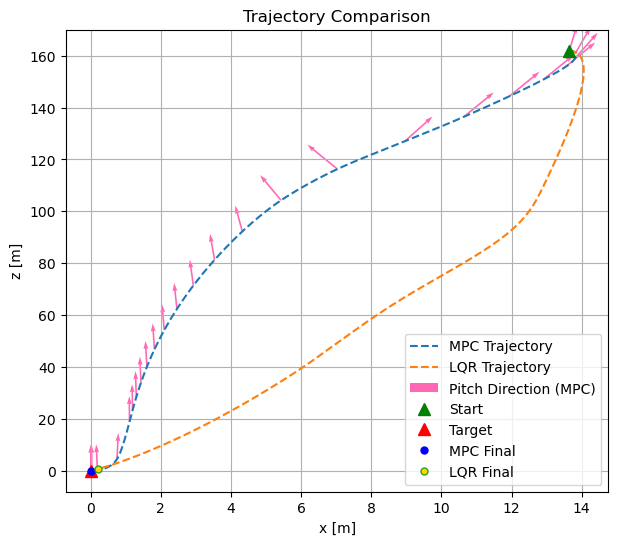

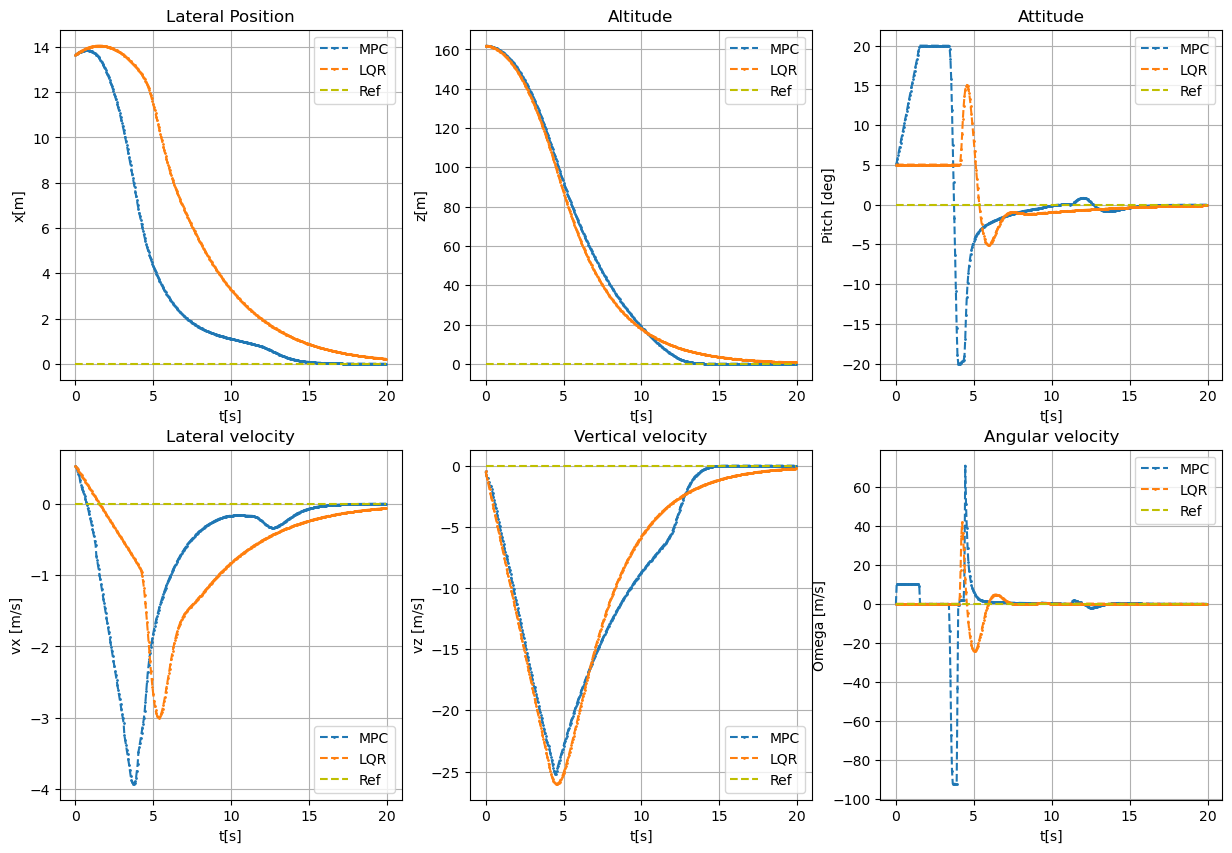

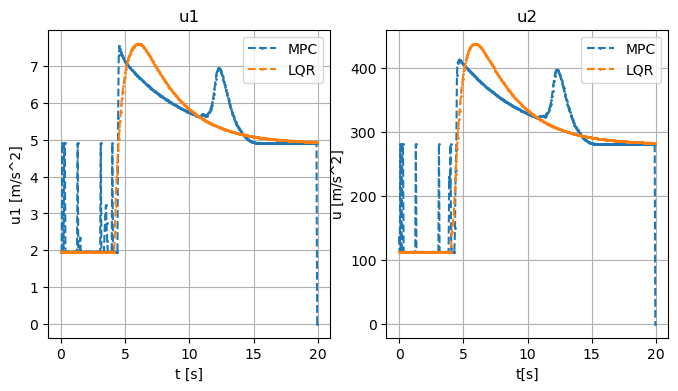

In [65]:
if __name__ == "__main__":

    h = 0.05
    tv = np.arange(0, 20, h)

    x0_mu = np.array([10.0, 150.0, np.deg2rad(0.0), 0.0, -2.0, 0.0])
    x0_std = np.array([5.0, 10.0, np.deg2rad(5.0), 1.0, 1.0, 0.0])
    x0 = np.array([np.random.normal(mu, sigma) for mu, sigma in zip(x0_mu, x0_std)])
    
    # x0 = np.array([5.0, 160.0, -0.133, 0.5, -10.0, 0.0])
    x_ref = np.array([0.0, 0.0, np.deg2rad(0.0), 0.0, 0.0, 0.0])
    
    g = 9.81
    m = 1.0
    u_hover = np.array([.5*m*g, .5*m*g])
    
    # MPC costs - start with same as LQR, then tune
    Q = np.diag([.25, .25, 5, 1, 1, 5])
    R = np.diag([.5, .5])
    Qf = 300*Q # final state is critical for landing
    
    N_mpc = 20 # 20 * 0.05 = MPC control evaluated in 1 second intervals
    
    print("\nRunning MPC controller... (tuned for mean initial conditions)")
    start_total = time.time()
    xstore_mpc, ustore_mpc, costs_mpc, solve_times = closed_loop_mpc_response(
           N_mpc, Q, R, Qf, x0, x_ref, u_hover, tv, h)
    total_time = time.time() - start_total

    print(f"\nMPC Total time: {total_time:.2f}s")
    print(f"Average solve time: {np.mean(solve_times[solve_times>0]):.4f}s")


    Q_lqr = np.diag([.1, .1, 5, 1, 1, 5])
    R_lqr = np.diag([1, 1])
    Qf_lqr = 100*Q_lqr # not used

    print("\nRunning LQR controller... (WARNING. prone to blow up!)")
    lqr = LQR_Controller(N_mpc, Q_lqr, R_lqr, Qf_lqr, x0, x_ref)
    xstore_lqr, ustore_lqr = lqr.closed_loop_lqr_response(x0, x_ref, u_hover, len(tv), Q_lqr, R_lqr)

    
    plt.figure(figsize=(7, 6))
    plt.plot(xstore_mpc[:,0], xstore_mpc[:,1], '--', markersize=2, label='MPC Trajectory')
    plt.plot(xstore_lqr[:,0], xstore_lqr[:,1], '--', markersize=2, label='LQR Trajectory')
    
    
    idxs = np.concatenate([np.arange(0, int(len(tv)/2), 10), np.arange(int(len(tv)/2), len(tv), 40)])
    theta = xstore_mpc[idxs, 2]
    dx = 5 * np.sin(theta)  # lateral arrow component
    dy = 20 * np.cos(theta)  # vertical arrow component
    plt.quiver(xstore_mpc[idxs,0], xstore_mpc[idxs,1], dx, dy, angles='xy', scale_units='xy', 
               scale=2, color='hotpink', width=0.003, label='Pitch Direction (MPC)')
    
    plt.plot(x0[0], x0[1], 'g^', markersize=8, label="Start")
    plt.plot(x_ref[0], x_ref[1], 'r^', markersize=8, label="Target")
    plt.plot(xstore_mpc[-1,0], xstore_mpc[-1,1], 'ob', markersize=5, label="MPC Final")
    plt.plot(xstore_lqr[-1,0], xstore_lqr[-1,1], 'o', markersize=5,  mfc='gold', label="LQR Final")
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.xlabel('x [m]')
    plt.ylabel('z [m]')
    plt.title('Trajectory Comparison')

    plt.figure(figsize=(15, 10))
    plt.subplot(2,3,1)
    plt.plot(tv, xstore_mpc[:,0], '--o', markersize=1, label='MPC')
    plt.plot(tv, xstore_lqr[:,0], '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[0]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('x[m]')
    plt.title('Lateral Position')

    plt.subplot(2,3,2)
    plt.plot(tv, xstore_mpc[:,1], '--o', markersize=1, label='MPC')
    plt.plot(tv, xstore_lqr[:,1], '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[1]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('z[m]')
    plt.title('Altitude')

    plt.subplot(2,3,3)
    plt.plot(tv, np.rad2deg(xstore_mpc[:,2]), '--o', markersize=1, label='MPC')
    plt.plot(tv, np.rad2deg(xstore_lqr[:,2]), '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[2]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('Pitch [deg]')
    plt.title('Attitude')

    plt.subplot(2,3,4)
    plt.plot(tv, xstore_mpc[:,3], '--o', markersize=1, label='MPC')
    plt.plot(tv, xstore_lqr[:,3], '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[3]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('vx [m/s]')
    plt.title('Lateral velocity')

    plt.subplot(2,3,5)
    plt.plot(tv, xstore_mpc[:,4], '--o', markersize=1, label='MPC')
    plt.plot(tv, xstore_lqr[:,4], '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[4]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('vz [m/s]')
    plt.title('Vertical velocity')

    plt.subplot(2,3,6)
    plt.plot(tv, np.rad2deg(xstore_mpc[:,5]), '--o', markersize=1, label='MPC')
    plt.plot(tv, np.rad2deg(xstore_lqr[:,5]), '--o', markersize=1, label='LQR')
    plt.plot(tv, x_ref[5]*np.ones((len(tv),1)), '--y', markersize=2, label='Ref')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('Omega [m/s]')
    plt.title('Angular velocity')

    #
    plt.figure(figsize=(8, 4))
    plt.subplot(1,2,1)
    plt.plot(tv, ustore_mpc[:,0], '--o', markersize=1, label='MPC')
    plt.plot(tv, ustore_lqr[:,0], '--o', markersize=1, label='LQR')
    plt.legend()
    plt.grid(True)
    plt.ylabel('u1 [m/s^2]')
    plt.xlabel('t [s]')
    plt.title('u1')

    plt.subplot(1,2,2)
    plt.plot(tv, np.rad2deg(ustore_mpc[:,1]), '--o', markersize=1, label='MPC')
    plt.plot(tv, np.rad2deg(ustore_lqr[:,1]), '--o', markersize=1, label='LQR')
    plt.legend()
    plt.grid(True)
    plt.xlabel('t[s]')
    plt.ylabel('u [m/s^2]')
    plt.title('u2')

    # Errors
    lqr_error = np.linalg.norm(xstore_lqr[-1] - x_ref)
    mpc_error = np.linalg.norm(xstore_mpc[-1] - x_ref)
    print(f"\nFinal tracking errors:")
    print(f"LQR: {lqr_error:.4f}")
    print(f"MPC: {mpc_error:.4f}")

# Notes

- Needed to constrain altitude $z \geq 0$ all the times as the landing is above the ground - requires optimization toolbox for inequality constraints.
- Linearization is tricky - choosing to linearize at hovering initial state or reference state - improvise on linearizing if having a reference trajectory.
    - Linearizing at current MPC optimal control output resulted in poor control along the trajectory. This is because, for example, when high thrust is demanded by controller - it may not a linear operating point.
    - A reference trajectory could make the trajectory corrections early on in the flight $[\textcolor{blue}{\text{Future work}}]$. For instance, a straight line trajectory $\mathbf{x}_\text{ref}$ helps in regularizing cost function in the MPC horizon and precompute linearization points. 

- LQR, at times, does well with the trajectory control - however there is no formalism in adding state constraints like MPC.
    - LQR seems to leverage that additional flexibility in states to reach desired faster. For example, $y$ can be negative.
    - Also, LQR struggles to work when moved far from linear operating state & control.
    - LQR does not really seem to like very tight constraints. It buckles when tighter constraints are enforced. MPC tends to work around hard constraints. 
- MPC is a receding horizon control. Meaning - it tries to plan control for a fixed time window into the future. Taking hints from the prediction of dynamics during the window as well as the remaining cost-to-go, MPC gives locally optimal control with the hope of global optimal policy.
    - A short MPC horizon computes faster but be myopic. A long horizon is compute inefficient (matrix operations). A medium horizon planning for the control, especially guided by a planned trajectory could help achieve real-time realization of MPC optimal control onboard.
    - Furthermore, I see the MPC very sensitive to the initial conditions. The same penalties are not applicable for all initial conditions - any bad state readout will topple the MPC chain as the linearization is computed at the current state and if the current state is far from linearization (e.g., high attitude or velocities). 

### Conclusion
Control requires careful tuning of penalties in states and costs. Apart from control constraints (hardware dependent), state constraints help define the control policy for maneuvering to the landing target. Careful tuning of the penalties in states, terminal state, and control dictates the trajectory performance. Not implemented here, but using a planned trajectory $\mathbf{x}_\text{ref}$ helps MPC react to fast dynamics early on. Moreover, MPC is compute heavy and implementations such as the above, are without any convergence guarantees. However, with pre-planned trajectory, a few computations can be performed offline and efficient embedded implementation could potentially yield at $20$ Hz onboard control rate or better. 

### Resources
- [OSQP documentation](https://pypi.org/project/osqp/)
- [MPC for convex optimization](https://www.youtube.com/watch?v=7aomMyPHKwI&t=3710s&ab_channel=CMURoboticExplorationLab)
- [MPC Quadratic Programming](https://www.youtube.com/watch?v=mVCjzMtj7yE&ab_channel=xLABforSafeAutonomousSystems)